In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [248]:
import os
import bossdata
import fitsio

import scipy.constants

from astropy.io import fits

In [3]:
def get_frame_file(plan_path, sequence_number, band, fiber):
    local_plan_path = mirror.get(plan_path)
    Plan = bossdata.plate.Plan(local_plan_path)
    exp_name_plan = Plan.get_exposure_name(sequence_number=sequence_number, band=band, fiber=fiber, 
                                           ftype='spFrame')
    local_fits = mirror.get(os.path.join(plan_path.strip(os.path.basename(plan_path)), 
                                         exp_name_plan))
    spec_index = Plan.get_spectrograph_index(fiber=fiber)
    FrameFile = bossdata.plate.FrameFile(path=local_fits, index=spec_index, calibrated=False)
    return fits.open(local_fits), FrameFile 

def get_flat_file(plate, mjd, sequence_number, camera):
    remote_plate_spec_path = finder.get_plate_spec_path(plate=plate, mjd=mjd)
    plate_spec_path = mirror.get(remote_plate_spec_path)
    PlateFile = bossdata.plate.PlateFile(plate_spec_path)
    exp_name_plate = PlateFile.exposures.get_exposure_name(exposure_index=sequence_number, 
                                                      camera=camera, ftype='spFlat')
    remote_plate_path = finder.get_plate_path(plate=plate, filename=exp_name_plate)
    plate_path = mirror.get(remote_plate_path)
    return fits.open(plate_path)

def get_cframe_file(plan_path, sequence_number, band, fiber):
    local_plan_path = mirror.get(plan_path)
    Plan = bossdata.plate.Plan(local_plan_path)
    exp_name_plan = Plan.get_exposure_name(sequence_number=sequence_number, band=band, fiber=fiber, 
                                           ftype='spCFrame')
    local_fits = mirror.get(os.path.join(plan_path.strip(os.path.basename(plan_path)), 
                                         exp_name_plan))
    return fits.open(local_fits)

### Put into a function

In [4]:
def get_ft(plate, mjd, fibers, sequence_number, band):
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    
    r = 250./2 # cm
    mirror_area = np.pi*r**2 # cm^2 
    h = scipy.constants.Planck
    c = scipy.constants.c
    
    for f in fibers:
        
        frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=f)
        flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
        cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                             band=band, fiber=f)
        
        eflux = frame[0].data # flux in flat-fielded electrons 
        fiberflat = flat[0].data
        superflat = frame[8].data
        flux = cframe[0].data # flux density in (10^{-17} erg/s/cm^2/A)
        electrons = eflux * superflat * fiberflat
        exp_time = cframe[0].header['EXPTIME'] #s
        wlen = 10**cframe[3].data


        if f > 499:
            fiber = np.mod(f, 500) # cannot access index > 499 in flux, electrons since they have shape (500, 4128/4122)
    
        flux = flux[f][:len(electrons[f])] # make sure to trim flux array if band = blue
    
        # keep positive flux values
        pos_flux = flux > 0.0
        flux = flux[pos_flux]
        electrons = electrons[f][pos_flux]
        wlen = wlen[f][pos_flux]
    
        wlen_interp = np.arange(wlen[0], wlen[-1]+1, 1.)
        flux_interp = np.interp(x=wlen_interp, xp=wlen, fp=flux)
        elec_interp = np.interp(x=wlen_interp, xp=wlen, fp=electrons)
    
        midpt = np.append((wlen_interp[1:]+wlen_interp[:-1])/2, wlen_interp[-1])
        
        num = flux_interp * mirror_area * exp_time * 1.
        denom = h * c / midpt
        photons = num / denom * (10**(-34)) # convert from Joules to ergs
                
    return midpt, elec_interp/photons

In [5]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

In [305]:
plate = 7027 
mjd = 56448
fiber = 200
sequence_number = 0

In [76]:
#fibers = [1, 2, 10, 50, 100, 200, 300, 450]
fibers = [6, 7, 8, 9, 10]
#fibers = [500, 501, 510, 550, 600, 700, 800, 950]

In [45]:
midpt, thru = get_ft(plate=plate, mjd=mjd, fibers=[1], sequence_number=sequence_number, band='red')

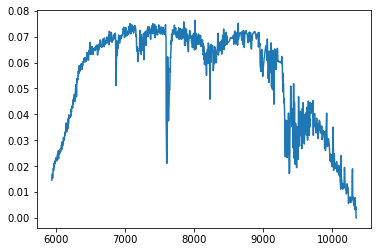

In [46]:
plt.plot(midpt, thru)
plt.show()

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4128 but corresponding boolean dimension is 4112


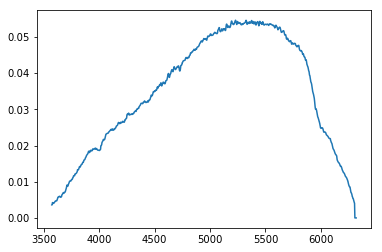

In [48]:
midpt, thru = get_ft(plate=plate, mjd=mjd, fibers=[1], sequence_number=sequence_number, band='blue')
plt.plot(midpt, thru)
plt.show()

## Include atmospheric extinction

- Need airmass (spCFrame) and extinction (desimodel) values

In [82]:
def get_ft_new(plate, mjd, fibers, sequence_number, band, dlam):
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    
    r = 250./2 # cm
    mirror_area = np.pi*r**2 # cm^2 
    h = scipy.constants.Planck
    c = scipy.constants.c
    
    extinct_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/ZenithExtinction-KPNO.dat')
    extinct = loadtxt(extinct_path)
    
    if band == 'blue':
        extinct_wlen = extinct[:,0][734:28175]
        extinct_coef = extinct[:,1][734:28175]
    else: 
        extinct_wlen = extinct[:,0][24455:]
        extinct_coef = extinct[:,1][24455:]
        
    for f in fibers:
        
        frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=f)
        flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
        cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                             band=band, fiber=f)
        
        eflux = frame[0].data # flux in flat-fielded electrons
        fiberflat = flat[0].data
        superflat = frame[8].data
        flux = cframe[0].data
        electrons = eflux * superflat * fiberflat
        exp_time = cframe[0].header['EXPTIME'] #s
        wlen = 10**cframe[3].data
        airmass = cframe[0].header['AIRMASS']
        

        if f > 499:
            fiber = np.mod(f, 500) # cannot access index > 499 in flux, electrons since they have shape (500, 4128/4122)
    
        flux = flux[f][:len(electrons[f])] # make sure to trim flux array if band = blue
    
        # keep positive flux values
        pos_flux = flux > 0.0
        flux = flux[pos_flux]
        electrons = electrons[f][pos_flux]
        wlen = wlen[f][pos_flux]
    
        
        wlen_interp = np.arange(wlen[0], wlen[-1]+1, float(dlam))
        flux_interp = np.interp(x=wlen_interp, xp=wlen, fp=flux)
        elec_interp = np.interp(x=wlen_interp, xp=wlen, fp=electrons)
        extinct_interp = np.interp(x=wlen_interp, xp=extinct_wlen, 
                                   fp=extinct_coef)
    
        midpt = np.append((wlen_interp[1:]+wlen_interp[:-1])/2, wlen_interp[-1])

        
        num = flux_interp * mirror_area * exp_time * dlam
        denom = h * c / midpt
        photons = num / denom * (10**(-34)) # convert from Joules to ergs
        
        exp = extinct_interp*airmass
        extinct = 10 ** (-exp/2.5)

        photons_ext = photons * extinct
        
    #return midpt, wlen_interp, elec_interp, photons_ext, photons
    return 10**cframe[3].data, eflux, superflat, fiberflat, extinct, wlen_interp

In [58]:
midpt, wlen, elec, pht_ext, pht = get_ft_new(plate=plate, mjd=mjd, fibers=[20], sequence_number=sequence_number, band='red', dlam=1.)

In [85]:
wlen, eflux, superflat, fiberflat, ex, wlen_in = get_ft_new(plate=plate, mjd=mjd, fibers=[20], sequence_number=sequence_number, band='red', dlam=1.)

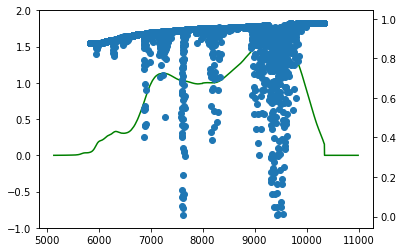

In [172]:
plt.plot(wlen[20], superflat[20], 'g')
plt.xlim(7500,8000)
plt.ylim(-1,2)
rhs = plt.twinx()
rhs.scatter(wlen_in, ex)

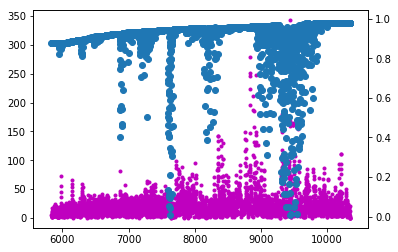

In [180]:
plt.plot(wlen_in, elec, 'm.')
rhs = plt.twinx()
rhs.scatter(wlen_in, ex)

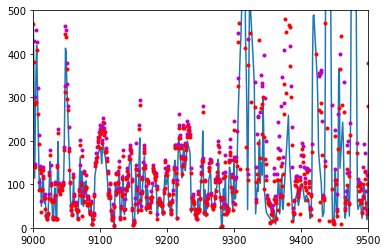

In [70]:
plt.plot(wlen, elec*5)
plt.xlim(9000,9500)
plt.ylim(0,500)
plt.plot(wlen, pht, 'm.')
plt.plot(wlen, pht_ext, 'r.');

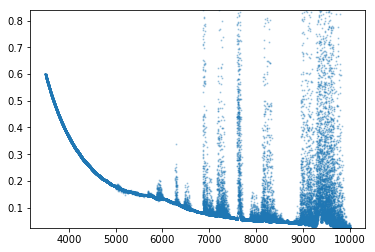

In [46]:
extinct_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/ZenithExtinction-KPNO.dat')
extinct = loadtxt(extinct_path)
ext_min, ext_max = np.percentile(extinct[:,1], (1, 99))
plt.scatter(extinct[:,0], extinct[:,1], s=1, alpha=0.3)
plt.ylim(ext_min, ext_max)
plt.show()

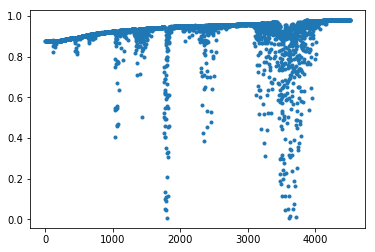

In [49]:
plt.plot(ex, '.');

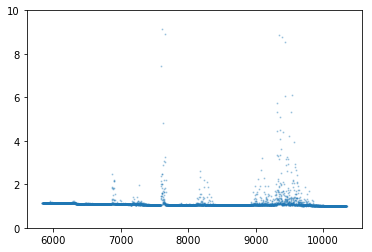

In [21]:
plt.scatter(wl, 1/ex, s=1, alpha=0.3)
plt.ylim(0,10);

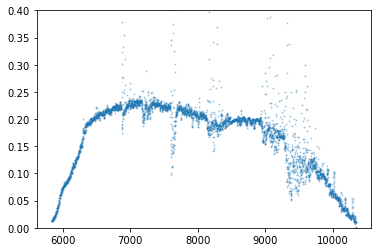

In [52]:
plt.scatter(midpt, thru_ext, alpha=0.3, s=1)
plt.ylim(0,0.4)
plt.show()

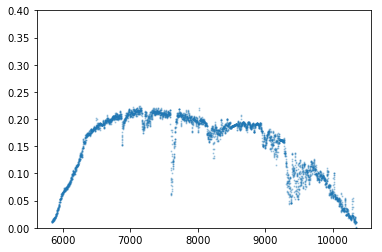

In [53]:
plt.scatter(midpt, thru, alpha=0.3, s=1)
plt.ylim(0,0.4)
plt.show()

In [706]:
def multi_plot(plate, mjd, fiber, band, wlen_min, wlen_max, dlam=1.0, airmass=None, save=None):
    
    sequence_number = 0
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    
    r = 250./2 # cm
    mirror_area = np.pi*r**2 # cm^2 
    h = scipy.constants.Planck
    c = scipy.constants.c
    
    extinct_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/ZenithExtinction-KPNO.dat')
    extinct = loadtxt(extinct_path)
    
    if band == 'blue':
        extinct_wlen = extinct[:,0][734:28175]
        extinct_coef = extinct[:,1][734:28175]
    else: 
        extinct_wlen = extinct[:,0][24455:]
        extinct_coef = extinct[:,1][24455:]
        
    frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=fiber)
    flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
    cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                         band=band, fiber=fiber)
    


    eflux = frame[0].data # flux in flat-fielded electrons
    fiberflat = flat[0].data
    superflat = frame[8].data
    flux = cframe[0].data
    electrons = eflux * superflat * fiberflat
    exp_time = cframe[0].header['EXPTIME'] #s
    wlen = 10**cframe[3].data #check to see if matches frame[3].data
    
    if airmass is None:
        airmass = cframe[0].header['AIRMASS']


    fiber = np.mod(fiber, 500) 
            
    flux = flux[fiber][:len(electrons[fiber])] # make sure to trim flux array if band = blue
    
    #keep everything
    # keep positive flux values
    pos_flux = flux > 0.0
    flux = flux[pos_flux]
    electrons = electrons[fiber][pos_flux]
    wlen = wlen[fiber][pos_flux]


    wlen_interp = np.arange(wlen[0], wlen[-1]+1, float(dlam))
    flux_interp = np.interp(x=wlen_interp, xp=wlen, fp=flux)
    elec_interp = np.interp(x=wlen_interp, xp=wlen, fp=electrons)
    extinct_interp = np.interp(x=wlen_interp, xp=extinct_wlen, 
                               fp=extinct_coef)
    
    superflat_interp = np.interp(x=wlen_interp, xp=wlen, 
                               fp=superflat[fiber][pos_flux])
    fiberflat_interp = np.interp(x=wlen_interp, xp=wlen, 
                               fp=fiberflat[fiber][pos_flux])

    midpt = np.append((wlen_interp[1:]+wlen_interp[:-1])/2, wlen_interp[-1])
    
    num = flux_interp * mirror_area * exp_time * dlam #np.diff(wlen)
    denom = h * c / midpt
    photons = num / denom * (10**(-34)) # convert from Joules to ergs

    exp = extinct_interp*airmass
    extinct = 10 ** (-exp/2.5)

    photons_ext = photons * extinct
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(12,11))
    
    fig.suptitle('{}'.format(cframe[5].data['OBJTYPE'][fiber], fontsize=14, fontweight='bold'), y=1.02)
    
    ax1.scatter(wlen_interp, flux_interp, alpha=0.3, s=1)
    ax1.set_title('Flux')
    ax1.set_xlabel('Wavelength [Angstrom]')
    ax1.set_ylabel(r'Flux $[10^{-17} erg/s/cm^2/A]$')
    ax1.set_xlim(wlen_min, wlen_max)
    flux_min, flux_max = np.percentile(flux_interp, (1, 99))
    ax1.set_ylim(flux_min, flux_max)
    
    ax2.scatter(wlen_interp, photons, alpha=0.3, s=1)
    ax2.set_title('Photons (no extinction)')
    ax2.set_xlabel('Wavelength [Angstrom]')
    ax2.set_ylabel('# Photons')
    ax2.set_xlim(wlen_min, wlen_max)
    photon_min, photon_max = np.percentile(photons, (1,99))
    ax2.set_ylim(photon_min, photon_max)
    
    ax3.scatter(wlen_interp, elec_interp, alpha=0.3, s=1)
    ax3.set_title('Electrons')
    ax3.set_xlabel('Wavelength [Angstrom]')
    ax3.set_ylabel('# Electrons')
    ax3.set_xlim(wlen_min, wlen_max)
    elec_min, elec_max = np.percentile(elec_interp, (1,99))
    ax3.set_ylim(elec_min, elec_max)
    
    ax4.scatter(wlen_interp, extinct, alpha=0.3, s=1)
    ax4.set_title('Extinction')
    ax4.set_xlabel('Wavelength [Angstrom]')
    ax4.set_ylabel('Extinction')
    ax4.set_xlim(wlen_min, wlen_max)
    
    ax5.scatter(wlen_interp, superflat_interp, alpha=0.3, s=1)
    ax5.set_title('Superflat')
    ax5.set_xlabel('Wavelength [Angstrom]')
    ax5.set_ylabel('# Electrons')
    ax5.set_xlim(wlen_min, wlen_max)
    
    ax6.scatter(wlen_interp, fiberflat_interp, alpha=0.3, s=1)
    ax6.set_title('Fiberflat')
    ax6.set_xlabel('Wavelength [Angstrom]')
    ax6.set_ylabel('# Electrons')
    ax6.set_xlim(wlen_min, wlen_max)
    
    ax7.scatter(wlen_interp, photons_ext, alpha=0.3, s=1)
    ax7.set_title('Photons (w/ extinction)')
    ax7.set_xlabel('Wavelength [Angstrom]')
    ax7.set_ylabel('# Electrons')
    ax7.set_xlim(wlen_min, wlen_max)
    photons_ext_min, photons_ext_max = np.percentile(photons_ext, (1,99))
    ax7.set_ylim(photons_ext_min, photons_ext_max)
    
    ax8.scatter(wlen_interp, elec_interp/photons_ext, alpha=0.3, s=1)
    ax8.set_title('Fiberloss x Throughput')
    ax8.set_xlabel('Wavelength [Angstrom]')
    ax8.set_ylabel('# Electrons / # Photons')
    ax8.set_xlim(wlen_min, wlen_max)
    thru_min, thru_max = np.percentile(elec_interp/photons_ext, (1,99))
    ax8.set_ylim(thru_min, thru_max)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save)
    
    plt.show()
    
    print(airmass)

In [228]:
print(plate,mjd,fiber)

(7027, 56448, 200)


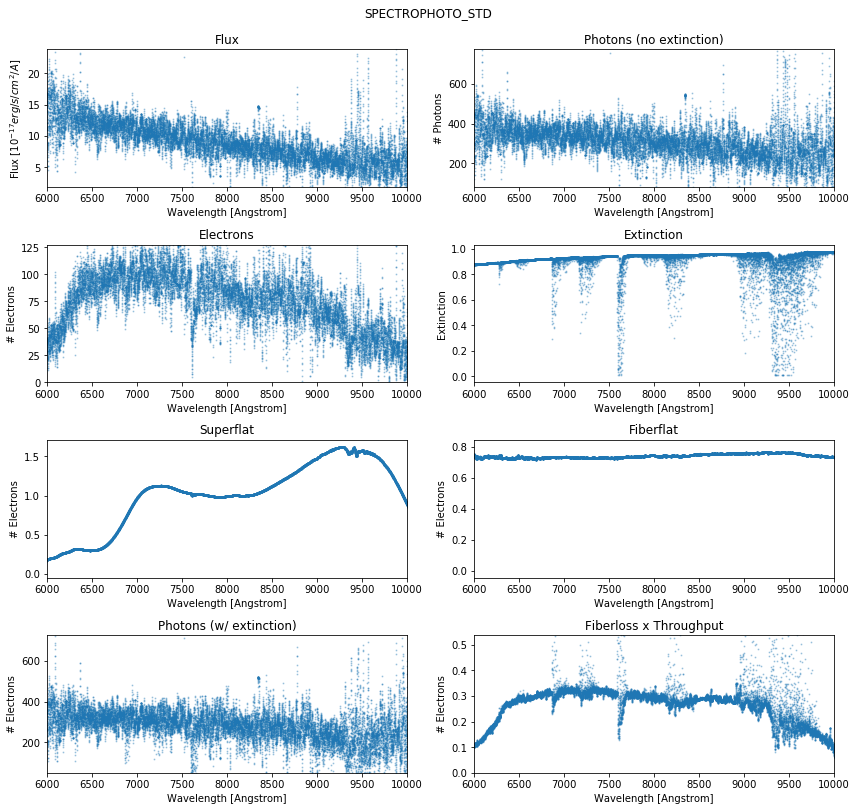

1.07283


In [301]:
multi_plot(plate=6511, mjd=56540, fiber=41, band='red', wlen_min=6000, wlen_max=10000, dlam=0.2)

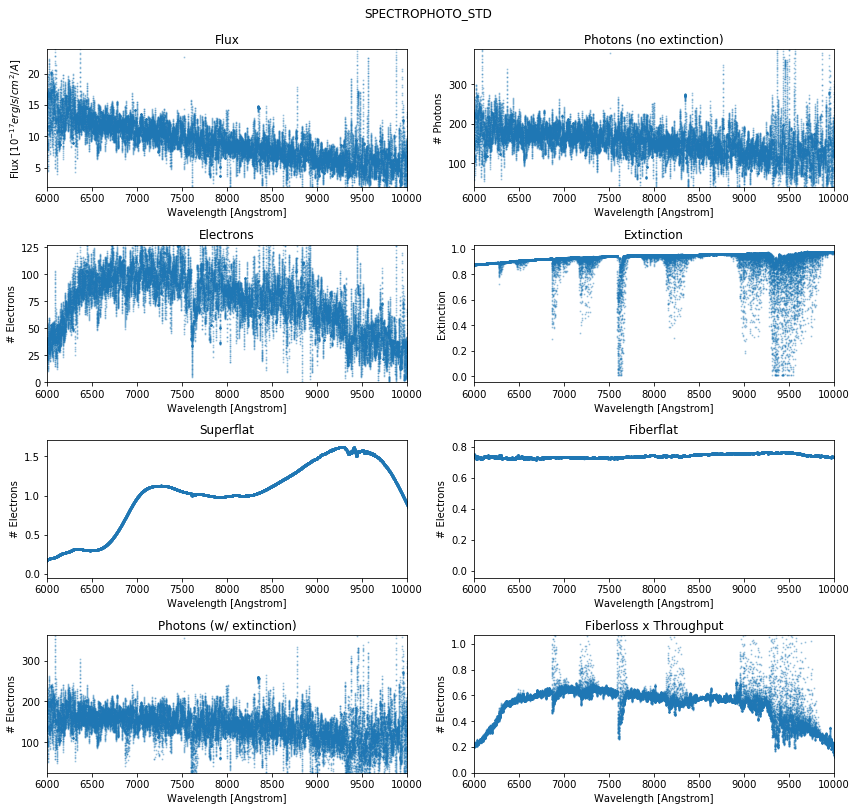

1.07283


In [300]:
multi_plot(plate=6511, mjd=56540, fiber=41, band='red', wlen_min=6000, wlen_max=10000, dlam=0.1)

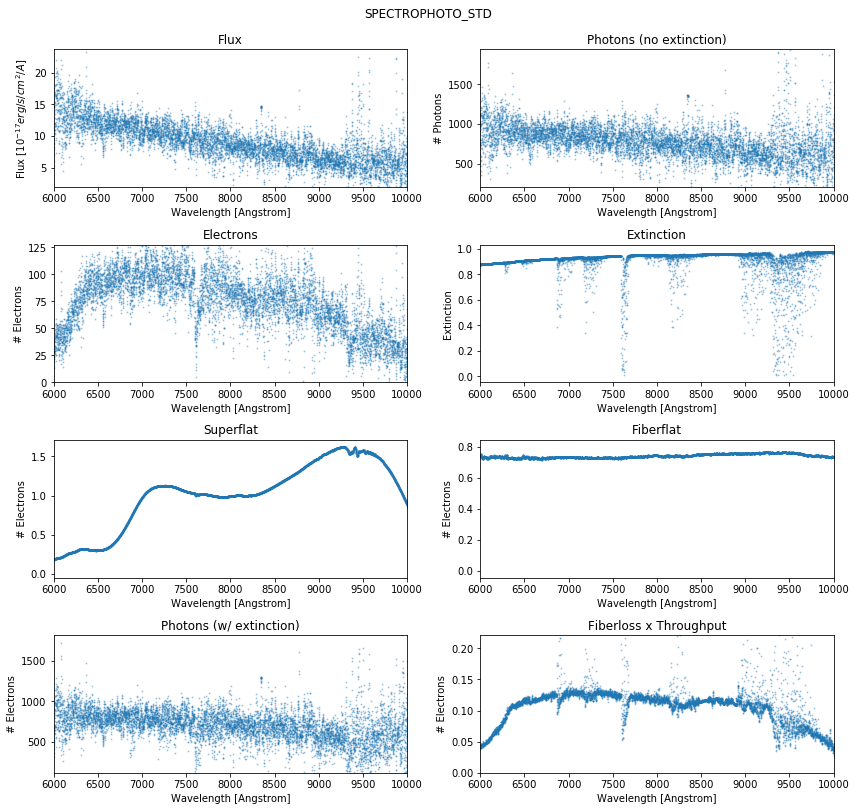

1.07283


In [298]:
multi_plot(plate=6511, mjd=56540, fiber=41, band='red', wlen_min=6000, wlen_max=10000, dlam=0.5)

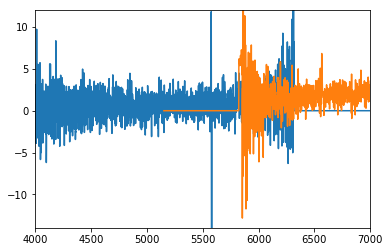

In [245]:
plan_path = finder.get_plate_plan_path(plate=6511, mjd=56540, combined=True)
cframe_b = get_cframe_file(plan_path=plan_path, sequence_number=0, 
                         band='blue', fiber=10)
cframe_r = get_cframe_file(plan_path=plan_path, sequence_number=0, 
                         band='red', fiber=10)
flux_b = cframe_b[0].data
wlen_b = 10**cframe_b[3].data

flux_r = cframe_r[0].data
wlen_r = 10**cframe_r[3].data

plt.plot(wlen_b[10], flux_b[10])
plt.plot(wlen_r[10], flux_r[10])
plt.xlim(4000,7000)
plt.ylim(-14,12)
plt.show()

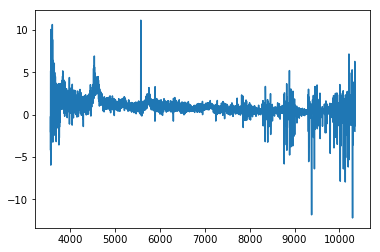

In [288]:
hdu = fits.open('/Users/belaabolfathi/Downloads/spec-6511-56540-0010.fits')
flux = hdu[1].data['flux']
wlen = 10 ** hdu[1].data['loglam']
plt.plot(wlen, flux)
plt.show()

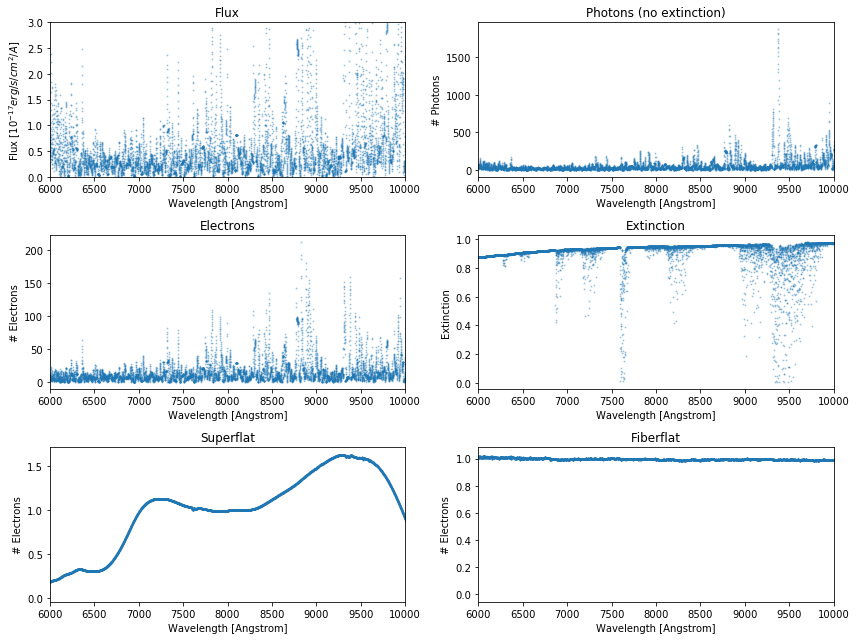

In [162]:
multi_plot(plate, mjd, fiber=205, band='red', wlen_min=6000, wlen_max=10000, dlam=0.5, save='7027-56448-200-r-0.5.png')

### Get standards

In [558]:
sequence_number = 0
plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band='blue', fiber=fiber)
flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                     band='blue', fiber=fiber)

spFrame-b1-00165737.fits.gz 100%|#################################|   4.13 kB/s


In [559]:
std = []
for i in range(len(cframe[5].data)):
    if cframe[5].data['OBJTYPE'][i] == 'SPECTROPHOTO_STD':
        std.append(i)

In [707]:
def new_multi_plot(plate, mjd, fiber, band, wlen_min, wlen_max, airmass=None, save=None):
    
    sequence_number = 0
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    
    r = 250./2 # cm
    mirror_area = np.pi*r**2 # cm^2 
    h = scipy.constants.Planck
    c = scipy.constants.c
    
    extinct_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/ZenithExtinction-KPNO.dat')
    extinct = loadtxt(extinct_path)
    
    if band == 'blue':
        extinct_wlen = extinct[:,0][734:28175]
        extinct_coef = extinct[:,1][734:28175]
    else: 
        extinct_wlen = extinct[:,0][24455:]
        extinct_coef = extinct[:,1][24455:]
        
    frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=fiber)
    flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
    cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                         band=band, fiber=fiber)
    


    eflux = frame[0].data # flux in flat-fielded electrons
    fiberflat = flat[0].data
    superflat = frame[8].data
    flux = cframe[0].data
    electrons = eflux * superflat * fiberflat
    exp_time = cframe[0].header['EXPTIME'] #s
    wlen = 10**cframe[3].data #check to see if matches frame[3].data
    
    if airmass is None:
        airmass = cframe[0].header['AIRMASS']


    fiber = np.mod(fiber, 500) 
    
    # make sure to trim flux array if band = blue
    flux = flux[fiber][:len(electrons[fiber])] 
    wlen = wlen[fiber][:len(electrons[fiber])]
    
    electrons = electrons[fiber]
    superflat = superflat[fiber]
    fiberflat = fiberflat[fiber]
    
    extinct_interp = np.interp(x=wlen, xp=extinct_wlen, 
                               fp=extinct_coef)
    
    midpt = np.append((wlen[1:]+wlen[:-1])/2, wlen[-1])
    
    dlam = np.diff(wlen)
    dlam = np.append(dlam, dlam[-1])
        
    num = flux * mirror_area * exp_time * dlam
    denom = h * c / midpt
    photons = num / denom * (10**(-34)) # convert from Joules to ergs

    exp = extinct_interp*airmass
    extinct = 10 ** (-exp/2.5)

    photons_ext = photons * extinct
        
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(12,11))
    
    fig.suptitle('{}'.format(cframe[5].data['OBJTYPE'][fiber], fontsize=14, fontweight='bold'), y=1.02)
    
  
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax1.set_title('Flux')
    ax1.set_xlabel('Wavelength [Angstrom]')
    ax1.set_ylabel(r'Flux $[10^{-17} erg/s/cm^2/A]$')
    ax1.set_xlim(wlen_min, wlen_max)
    flux_min, flux_max = np.percentile(flux, (1, 99))
    ax1.set_ylim(flux_min, flux_max)
    
    ax2.scatter(wlen, photons, alpha=0.3, s=1)
    ax2.set_title('Photons (no extinction)')
    ax2.set_xlabel('Wavelength [Angstrom]')
    ax2.set_ylabel('# Photons')
    ax2.set_xlim(wlen_min, wlen_max)
    photon_min, photon_max = np.percentile(photons, (1,99))
    ax2.set_ylim(photon_min, photon_max)
    
    ax3.scatter(wlen, electrons, alpha=0.3, s=1)
    ax3.set_title('Electrons')
    ax3.set_xlabel('Wavelength [Angstrom]')
    ax3.set_ylabel('# Electrons')
    ax3.set_xlim(wlen_min, wlen_max)
    elec_min, elec_max = np.percentile(electrons, (1,99))
    ax3.set_ylim(elec_min, elec_max)
    
    ax4.scatter(wlen, extinct, alpha=0.3, s=1)
    ax4.set_title('Extinction')
    ax4.set_xlabel('Wavelength [Angstrom]')
    ax4.set_ylabel('Extinction')
    ax4.set_xlim(wlen_min, wlen_max)
    
    ax5.scatter(wlen, superflat, alpha=0.3, s=1)
    ax5.set_title('Superflat')
    ax5.set_xlabel('Wavelength [Angstrom]')
    ax5.set_ylabel('# Electrons')
    ax5.set_xlim(wlen_min, wlen_max)
    
    ax6.scatter(wlen, fiberflat, alpha=0.3, s=1)
    ax6.set_title('Fiberflat')
    ax6.set_xlabel('Wavelength [Angstrom]')
    ax6.set_ylabel('# Electrons')
    ax6.set_xlim(wlen_min, wlen_max)
    
    ax7.scatter(wlen, photons_ext, alpha=0.3, s=1)
    ax7.set_title('Photons (w/ extinction)')
    ax7.set_xlabel('Wavelength [Angstrom]')
    ax7.set_ylabel('# Electrons')
    ax7.set_xlim(wlen_min, wlen_max)
    photons_ext_min, photons_ext_max = np.percentile(photons_ext, (1,99))
    ax7.set_ylim(photons_ext_min, photons_ext_max)
    
    thru = np.nan_to_num(electrons/photons_ext)
    
    ax8.scatter(wlen, thru, alpha=0.3, s=1)
    ax8.set_title('Fiberloss x Throughput')
    ax8.set_xlabel('Wavelength [Angstrom]')
    ax8.set_ylabel('# Electrons / # Photons')
    ax8.set_xlim(wlen_min, wlen_max)
    thru_min, thru_max = np.percentile(thru, (4,99))
    ax8.set_ylim(thru_min, thru_max)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save)
    
    plt.show()
    
    return(photons, photons_ext)

In [383]:
band = 'blue'

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide


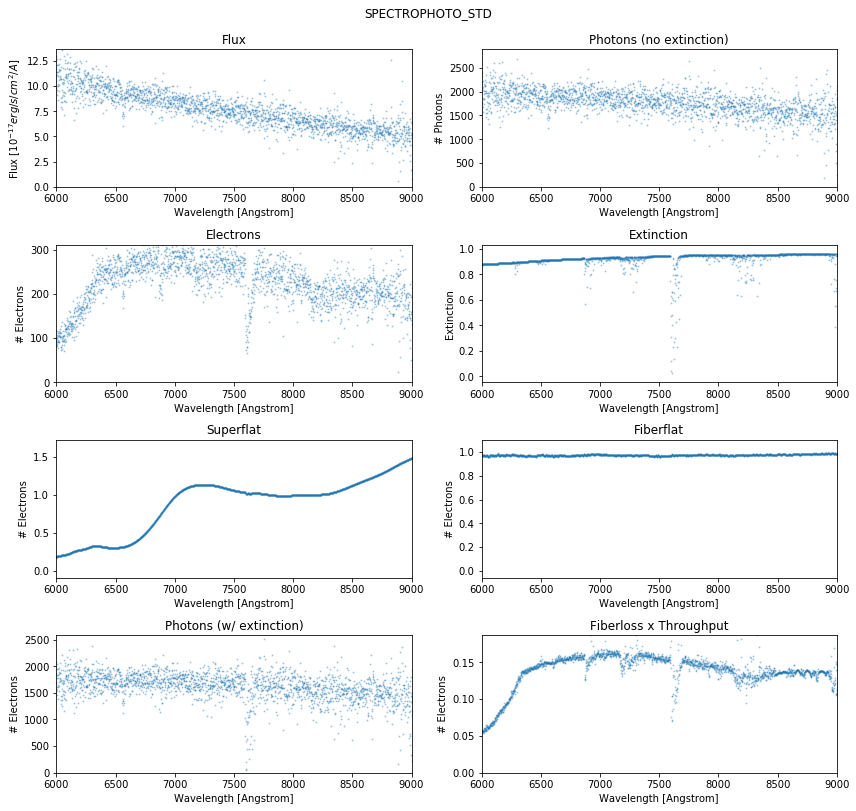

In [424]:
ph, ph_ex = new_multi_plot(plate=plate, mjd=mjd, fiber=std[0], band=band, wlen_min=6000, wlen_max=9000, airmass=None, save=None)

In [701]:
def get_spectra_data(plate, mjd, fiber, band, airmass=None):
    sequence_number = 0
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    
    r = 250./2 # cm
    mirror_area = np.pi*r**2 # cm^2 
    h = scipy.constants.Planck
    c = scipy.constants.c
    
    extinct_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/ZenithExtinction-KPNO.dat')
    extinct = loadtxt(extinct_path)
    
    if band == 'blue':
        extinct_wlen = extinct[:,0][:37050]
        extinct_coef = extinct[:,1][:37050]
    else: 
        extinct_wlen = extinct[:,0][16450:]
        extinct_coef = extinct[:,1][16450:]
        
    frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=fiber)
    flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
    cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                         band=band, fiber=fiber)
    

    eflux = frame[0].data # flux in flat-fielded electrons
    flux = cframe[0].data
    fiberflat = flat[0].data
    superflat = frame[8].data
    electrons = eflux * superflat * fiberflat
    exp_time = cframe[0].header['EXPTIME'] #s
    wlen = 10**cframe[3].data #check to see if matches frame[3].data
    
    if airmass is None:
        airmass = cframe[0].header['AIRMASS']

    fiber = np.mod(fiber, 500) 
    print(cframe[5].data['OBJTYPE'][fiber])
    
    
    # make sure to trim flux array if band = blue
    flux = flux[fiber][:len(electrons[fiber])] 
    wlen = wlen[fiber][:len(electrons[fiber])]
    
    electrons = electrons[fiber]
    
    extinct_interp = np.interp(x=wlen, xp=extinct_wlen, 
                               fp=extinct_coef)
    
    midpt = np.append((wlen[1:]+wlen[:-1])/2, wlen[-1])
    
    dlam = np.diff(wlen)
    dlam = np.append(dlam, dlam[-1])
        
    num = flux * mirror_area * exp_time * dlam
    denom = h * c / midpt
    photons = num / denom * (10**(-34)) # convert from Joules to ergs

    exp = extinct_interp*airmass
    extinct = 10 ** (-exp/2.5)

    photons_ext = photons * extinct
        
    #return(wlen, electrons/photons_ext)    
    return(wlen, electrons/photons_ext, flux)

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


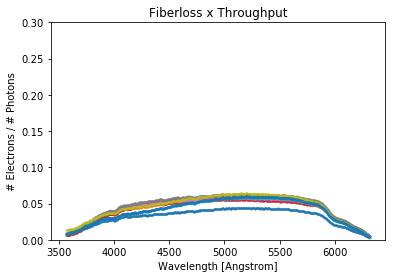

In [704]:
for i in range(len(std)):
    wlen, thru, flux = get_spectra_data(plate=plate, mjd=mjd, fiber=std[i], band='blue', airmass=None)
    plt.scatter(wlen, thru, alpha=0.3, s=1)
plt.title('Fiberloss x Throughput')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('# Electrons / # Photons')
plt.ylim(0,0.3)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: divide by zero encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


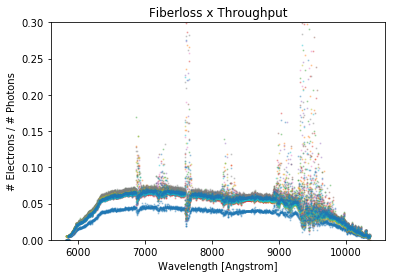

In [705]:
for i in range(len(std)):
    wlen, thru, flux = get_spectra_data(plate=plate, mjd=mjd, fiber=std[i], band='red', airmass=None)
    plt.scatter(wlen, thru, alpha=0.3, s=1)
plt.title('Fiberloss x Throughput')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('# Electrons / # Photons')
plt.ylim(0,0.3)
plt.show()

In [560]:
std

[41, 79, 133, 231, 259, 279, 329, 334, 441, 467, 477]

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning: divide by zero encountered in divide


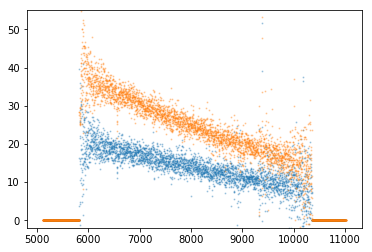

In [578]:
wlen_std3, thru_std3, flux_std3 = get_spectra_data(plate=plate, mjd=mjd, fiber=std[3], band='red', airmass=None)
wlen_std1, thru_std1, flux_std1 = get_spectra_data(plate=plate, mjd=mjd, fiber=std[1], band='red', airmass=None)
plt.scatter(wlen_std1, flux_std1, alpha=0.3, s=1)
plt.scatter(wlen_std3, flux_std3, alpha=0.3, s=1)
plt.ylim(-2,55)
plt.show()

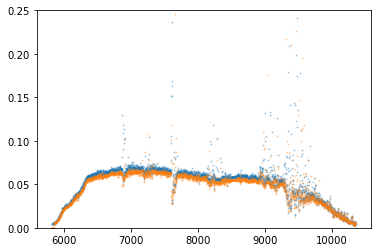

In [577]:
plt.scatter(wlen_std1, thru_std1, alpha=0.3, s=1)
plt.scatter(wlen_std3, thru_std3, alpha=0.3, s=1)
plt.ylim(0,0.25)
plt.show()

In [557]:
plate = 6511
mjd = 56540

In [543]:
#get_spectra_data(plate=plate, mjd=mjd, fiber=0, band='red', airmass=None)

In [534]:
wlen28, thru28, flux28 = get_spectra_data(plate=plate, mjd=mjd, fiber=28, band='red', airmass=None)
wlen127, thru127, flux127 = get_spectra_data(plate=plate, mjd=mjd, fiber=127, band='red', airmass=None)

GALAXY


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in divide


GALAXY


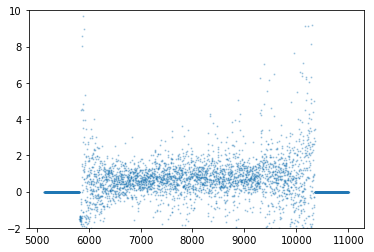

In [537]:
plt.scatter(wlen28, flux28, s=1, alpha=0.3)
plt.ylim(-2,10);

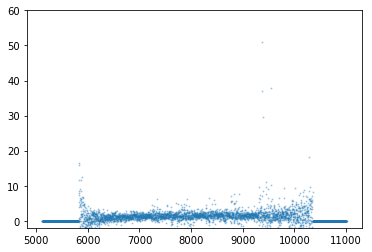

In [547]:
plt.scatter(wlen128, flux128, s=1, alpha=0.3)
plt.ylim(-2,60);

GALAXY


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in divide


GALAXY


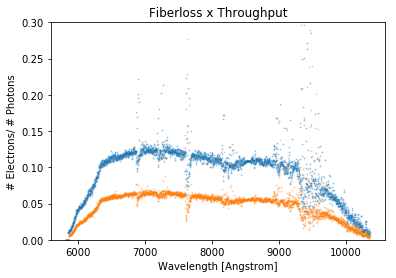

In [546]:
for i in [28, 127]:
    wlen, thru = get_spectra_data(plate=plate, mjd=mjd, fiber=i, band='red', airmass=None)
    plt.scatter(wlen, thru, alpha=0.3, s=1)
plt.title('Fiberloss x Throughput')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('# Electrons/ # Photons')
plt.ylim(0,0.3)
plt.show()

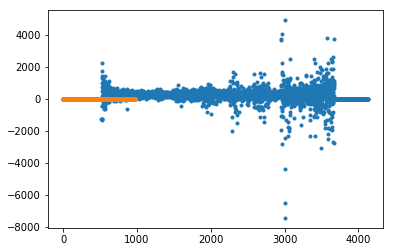

In [400]:
plt.plot(ph, '.')
plt.plot(ph[ph==0.0],'.')

In [401]:
ph[4120] == 0.0

True

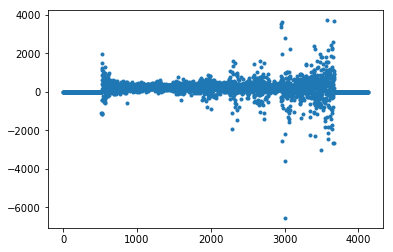

In [390]:
plt.plot(ph_ex, '.')

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4128 but corresponding boolean dimension is 4112
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


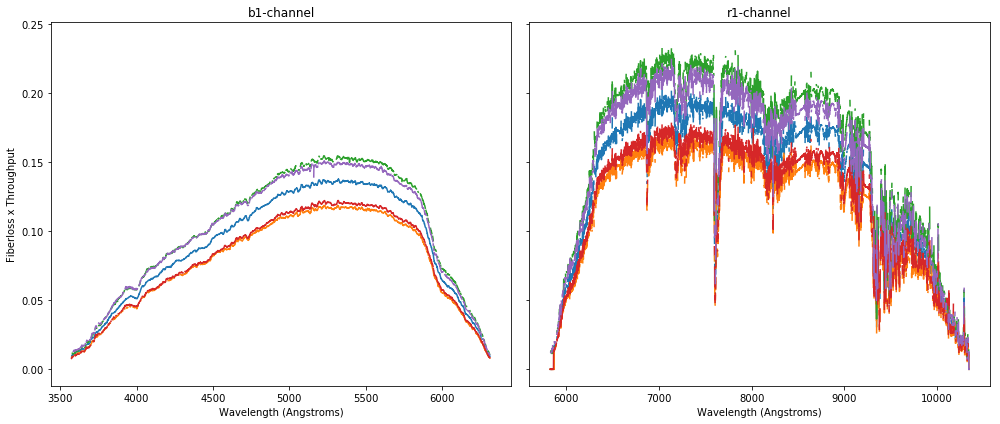

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=True)
for i, fiber in enumerate(fibers):
    x, y = get_ft(plate=plate, mjd=mjd, fiber=fiber, sequence_number=sequence_number, band='blue', dlam=1.0)
    ax1.plot(x, y)
ax1.set_title('b1-channel')    
ax1.set_xlabel('Wavelength (Angstroms)')
ax1.set_ylabel('Fiberloss x Throughput')
for i, fiber in enumerate(fibers):
    x, y = get_ft(plate=plate, mjd=mjd, fiber=fiber, sequence_number=sequence_number, band='red', dlam=1.0)
    ax2.plot(x, y)
ax2.set_title('r1-channel')
ax2.set_xlabel('Wavelength (Angstroms)')
plt.tight_layout()
#plt.savefig('thru1_7072_56448.png')

In [ ]:
#look at same fiber on different plate mjd to see if low blue fiber goes away
# cart id hdu 0 of spcframe to see if problem is on a particular cartridge
#look at fiber one on two different cartridges to isolate issue
# get extinction table from desimodel (named in desi/config)

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide


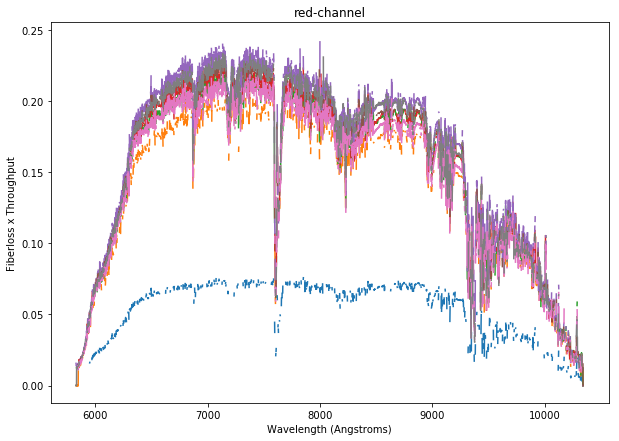

In [76]:
fig = plt.figure(figsize=(10,7))
for i, fiber in enumerate(fibers):
    x, y = get_ft(plate=plate, mjd=mjd, fiber=fiber, sequence_number=sequence_number, band=band, dlam=1.0)
    plt.plot(x, y)
plt.title('red-channel')    
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Fiberloss x Throughput')
plt.savefig('red_thru_7072_56448.png')

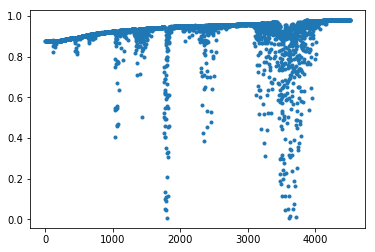

In [232]:
plt.plot(atmos, '.')

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4128 but corresponding boolean dimension is 4112
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide


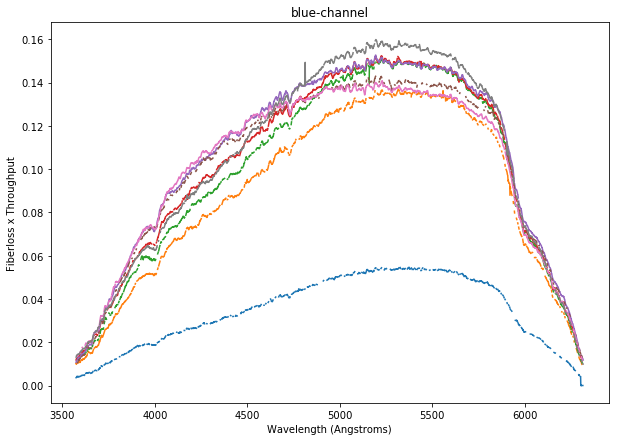

In [77]:
fig = plt.figure(figsize=(10,7))
for i, fiber in enumerate(fibers):
    x, y = get_ft(plate=plate, mjd=mjd, fiber=fiber, sequence_number=sequence_number, band='blue', dlam=1.0)
    plt.plot(x, y)
plt.title('blue-channel')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Fiberloss x Throughput')
plt.savefig('blue_thru_7072_56448.png')

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4128 but corresponding boolean dimension is 4112
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


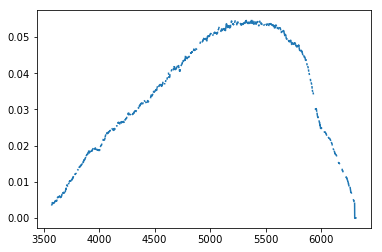

In [27]:
x, y = get_ft(plate=plate, mjd=mjd, fiber=1, sequence_number=sequence_number, band='blue', dlam=1.0)
plt.plot(x,y)
plt.show()

/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4128 but corresponding boolean dimension is 4112
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


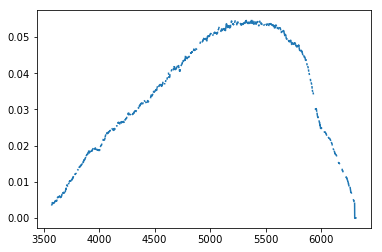

In [132]:
band = 'blue'
x, y = get_ft(plate=plate, mjd=mjd, fiber=1, sequence_number=sequence_number, band=band, dlam=1.0)
plt.plot(x,y)
plt.show()

##### why does throughput decrease when we increase dlam?
##### are narrow lines in the red band due to sky emission?


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4128 but corresponding boolean dimension is 4112
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


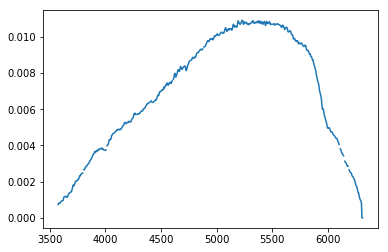

In [133]:
# why does throughput decrease when we increase dlam?
x, y = get_ft(plate=plate, mjd=mjd, fiber=1, sequence_number=sequence_number, band=band, dlam=5.0)
plt.plot(x,y)
plt.show()

In [51]:
plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                             band=band, fiber=fiber)
wlen = 10**cframe[3].data[1]
flux = cframe[0].data[1]

In [58]:
edg = np.arange(wlen[0], wlen[-1]+1, 15.)
flx = np.histogram(wlen, bins=edg, weights=flux)[0]

In [59]:
midpt = (edg[1:]+edg[:-1])/2

## Compare throughputs of spectrophotometric standard stars

In [ ]:
specify plate, mjd, get list of stars

In [579]:
def get_standards(plate, mjd, fiber, band):
    sequence_number = 0
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=fiber)
    flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
    cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                         band=band, fiber=fiber)
    std = []
    for i in range(len(cframe[5].data)):
        if cframe[5].data['OBJTYPE'][i] == 'SPECTROPHOTO_STD':
            std.append(i)
            
    return(frame, flat, cframe, std)

In [610]:
def get_star_spectra(frame, flat, cframe, fiber, airmass=None):
    
    r = 250./2 # cm
    mirror_area = np.pi*r**2 # cm^2 
    h = scipy.constants.Planck
    c = scipy.constants.c
    
    extinct_path = os.path.join(os.getenv('DESIMODEL'), 'data/spectra/ZenithExtinction-KPNO.dat')
    extinct = loadtxt(extinct_path)
    
    if band == 'blue':
        extinct_wlen = extinct[:,0][:37050]
        extinct_coef = extinct[:,1][:37050]
    else: 
        extinct_wlen = extinct[:,0][16450:]
        extinct_coef = extinct[:,1][16450:]
    
    eflux = frame[0].data # flux in flat-fielded electrons
    flux = cframe[0].data
    fiberflat = flat[0].data
    superflat = frame[8].data
    electrons = eflux * superflat * fiberflat
    exp_time = cframe[0].header['EXPTIME'] #s
    wlen = 10**cframe[3].data #check to see if matches frame[3].data
    
    if airmass is None:
        airmass = cframe[0].header['AIRMASS']


    print(cframe[5].data['OBJTYPE'][fiber])
    
    
    # make sure to trim flux array if band = blue
    flux = flux[fiber][:len(electrons[fiber])] 
    wlen = wlen[fiber][:len(electrons[fiber])]
    
    electrons = electrons[fiber]
    
    extinct_interp = np.interp(x=wlen, xp=extinct_wlen, 
                               fp=extinct_coef)
    
    midpt = np.append((wlen[1:]+wlen[:-1])/2, wlen[-1])
    
    dlam = np.diff(wlen)
    dlam = np.append(dlam, dlam[-1])
        
    num = flux * mirror_area * exp_time * dlam
    denom = h * c / midpt
    photons = num / denom * (10**(-34)) # convert from Joules to ergs

    exp = extinct_interp*airmass
    extinct = 10 ** (-exp/2.5)

    photons_ext = photons * extinct
        
    return(wlen, electrons/photons_ext, flux)

#### PLATE 6511 MJD 56540

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


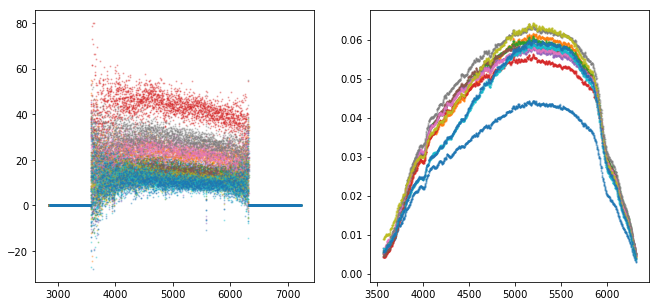

In [695]:
frame, flat, cframe, std = get_standards(plate=6511, mjd=56540, fiber=1, band='blue')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


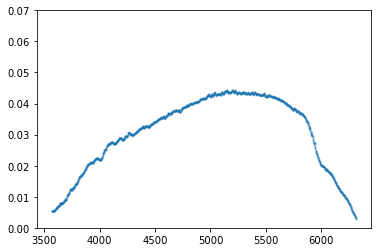

In [676]:
wlen0, thru0, flux0 = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[0], airmass=None)
plt.scatter(wlen0, thru0, alpha=0.3, s=1)
plt.ylim(0,.07)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


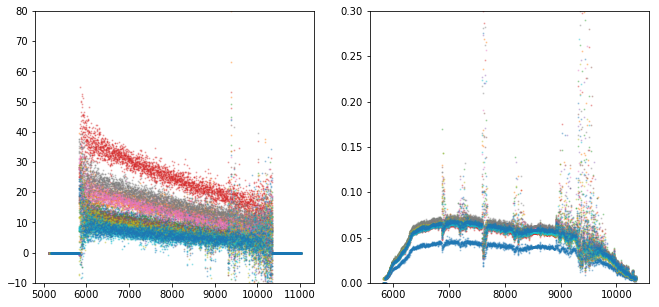

In [696]:
frame, flat, cframe, std = get_standards(plate=6511, mjd=56540, fiber=1, band='red')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,80)
ax2.set_ylim(0,0.3)
plt.show()

In [700]:
print(std)
print(std[0])

[41, 79, 133, 231, 259, 279, 329, 334, 441, 467, 477]
41


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


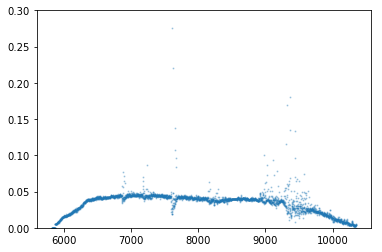

In [698]:
wlen0, thru0, flux0 = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[0], airmass=None)
plt.scatter(wlen0, thru0, alpha=0.3, s=1)
plt.ylim(0,.3)
plt.show()

In [699]:
print(cframe[5].data['XFOCAL'][std[0]], cframe[5].data['YFOCAL'][std[0]])

(191.04080999999999, -235.30144000000001)


#### PLATE 7114 MJD 56748

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


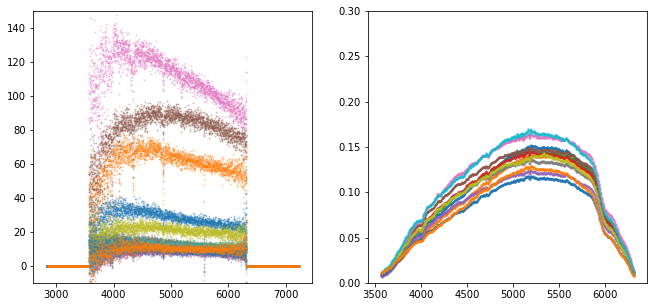

In [615]:
frame, flat, cframe, std = get_standards(plate=7114, mjd=56748, fiber=1, band='blue')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,150)
ax2.set_ylim(0,0.3)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


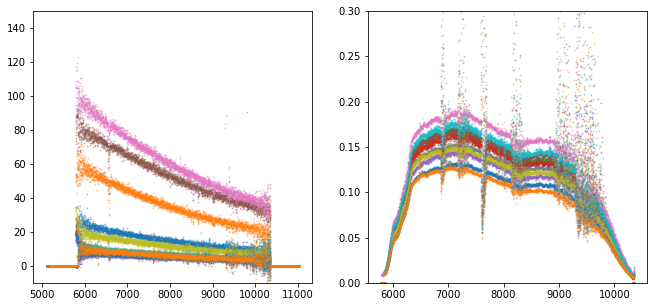

In [683]:
frame, flat, cframe, std = get_standards(plate=7114, mjd=56748, fiber=1, band='red')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,150)
ax2.set_ylim(0,0.3)
plt.show()

In [684]:
print(std)
print(std[10], std[11])

[29, 45, 91, 107, 135, 269, 311, 343, 389, 415, 439, 483]
(439, 483)


In [686]:
print(cframe[5].data['XFOCAL'][std[10]], cframe[5].data['YFOCAL'][std[10]])
print(cframe[5].data['XFOCAL'][std[11]], cframe[5].data['YFOCAL'][std[11]])

(-211.75539000000001, -145.55313000000001)
(-269.26528999999999, -168.76831999999999)


In [689]:
print(np.min(cframe[5].data['XFOCAL']), np.max(cframe[5].data['XFOCAL']))
print(np.min(cframe[5].data['YFOCAL']), np.max(cframe[5].data['YFOCAL']))

(-303.86462, 319.43403999999998)
(-314.4212, 13.050769000000001)


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide


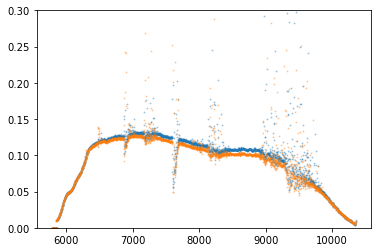

In [649]:
wlen10, thru10, flux10 = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[10], airmass=None)
wlen11, thru11, flux11 = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[11], airmass=None)
plt.scatter(wlen10, thru10, alpha=0.3, s=1)
plt.scatter(wlen11, thru11, alpha=0.3, s=1)
plt.ylim(0,.3)
plt.show()

#### PLATE 7396 MJD 56809

spFrame-b1-00180396.fits.gz 100%|#################################|   3.32 kB/s
spPlate-7396-56809.fits 100%|#####################################|   4.10 kB/s


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


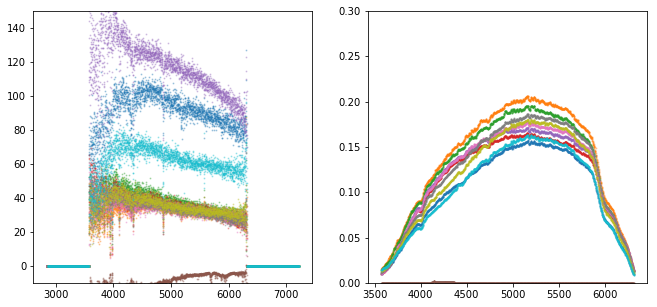

In [617]:
frame, flat, cframe, std = get_standards(plate=7396, mjd=56809, fiber=1, band='blue')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,150)
ax2.set_ylim(0,0.3)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


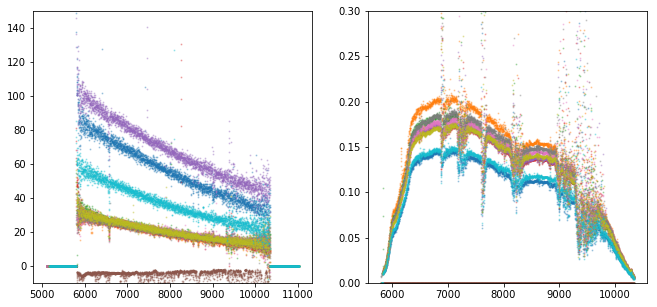

In [690]:
frame, flat, cframe, std = get_standards(plate=7396, mjd=56809, fiber=1, band='red')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,150)
ax2.set_ylim(0,0.3)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide


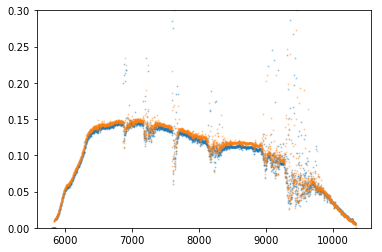

In [638]:
wlen0, thru0, flux0 = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[0], airmass=None)
wlen9, thru9, flux9 = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[9], airmass=None)
plt.scatter(wlen0, thru0, alpha=0.3, s=1)
plt.scatter(wlen9, thru9, alpha=0.3, s=1)
plt.ylim(0,.3)
plt.show()

In [694]:
print(cframe[5].data['XFOCAL'][std[0]], cframe[5].data['YFOCAL'][std[0]])
print(cframe[5].data['XFOCAL'][std[9]], cframe[5].data['YFOCAL'][std[9]])

(285.19412999999997, -132.25918999999999)
(-253.18929, -188.21964)


In [692]:
print(std)
print(std[0], std[9])

[6, 50, 55, 231, 273, 318, 333, 417, 466, 480]
(6, 480)


#### PLATE 6882 MJD 56541

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


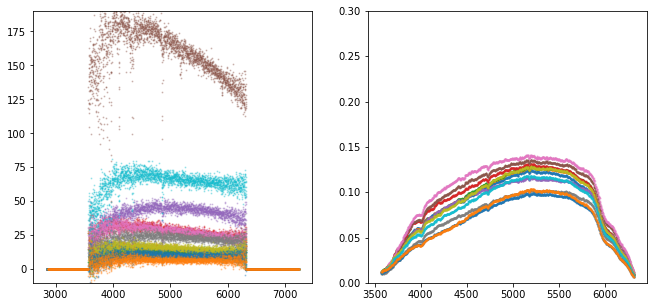

In [622]:
frame, flat, cframe, std = get_standards(plate=6882, mjd=56541, fiber=1, band='blue')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,190)
ax2.set_ylim(0,0.3)
plt.show()

SPECTROPHOTO_STD


/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in divide
/Users/belaabolfathi/anaconda3/envs/bossdata/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD
SPECTROPHOTO_STD


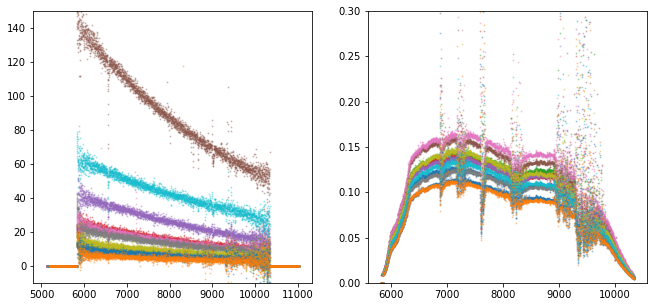

In [620]:
frame, flat, cframe, std = get_standards(plate=6882, mjd=56541, fiber=1, band='red')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
for i in range(len(std)):
    wlen, thru, flux = get_star_spectra(frame=frame, flat=flat, cframe=cframe, fiber=std[i], airmass=None)
    ax1.scatter(wlen, flux, alpha=0.3, s=1)
    ax2.scatter(wlen, thru, alpha=0.3, s=1)
ax1.set_ylim(-10,150)
ax2.set_ylim(0,0.3)
plt.show()

#### it's not necessarily the case that the star with the highest flux has the lowest throughput ...

plot all standards on a nominal wavelength grid by interpolating and then taking the median, may then need to add smoothing

In [ ]:
def get_files(plate, mjd, fiber, band):
    sequence_number = 0
    
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    frame, FrameFile = get_frame_file(plan_path=plan_path, sequence_number=sequence_number, 
                                      band=band, fiber=fiber)
    flat = get_flat_file(plate=plate, mjd=mjd, sequence_number=sequence_number, camera=FrameFile.camera)
    cframe = get_cframe_file(plan_path=plan_path, sequence_number=sequence_number, 
                         band=band, fiber=fiber)
    std = []
    for i in range(len(cframe[5].data)):
        if cframe[5].data['OBJTYPE'][i] == 'SPECTROPHOTO_STD':
            std.append(i)
            
    return(frame, flat, cframe)

def get_standards()